In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import resample

# 1. Load data
df = pd.read_csv('/content/Final_Merged_Dataset.csv')

# 2. Filter out full-term and ultra-short prepayments
df = df[df['MonthsInRepayment'] < 180]
df = df[df['MonthsInRepayment'] > 3]

# 3. Ensure interest rate columns are numeric
df['OrigInterestRate'] = pd.to_numeric(df['OrigInterestRate'], errors='coerce')
df['MortgageRate'] = pd.to_numeric(df['MortgageRate'], errors='coerce')

# 4. Calculate RateSpread = OrigInterestRate - MortgageRate
df['RateSpread'] = df['OrigInterestRate'] - df['MortgageRate']

# 5. Drop irrelevant or multicollinear columns
drop_cols = [
    'Unnamed: 0',
    'Parsed_FirstPaymentDate', 'Parsed_MaturityDate',
    'FirstPayment_Month', 'Maturity_Month',
    'SellerName', 'ServicerName',
    'OrigLoanTerm', 'FirstPayment_Year', 'Maturity_Year', 'OCLTV',
    'PrepayMonth'  # only used for matching mortgage rates
]
df.drop(columns=drop_cols, inplace=True, errors='ignore')

# 6. Encode categorical variables
label_enc = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = label_enc.fit_transform(df[col])

# 7. Drop rows with any missing values (just to be safe)
df.dropna(inplace=True)

# 8. Define features and target
y = df['MonthsInRepayment']
X = df.drop(columns=['MonthsInRepayment'])

# 9. Normalize features (important for linear models and MLP)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 1. Make a copy and drop the two rate columns
X_lr = X.copy()
X_lr.drop(columns=['OrigInterestRate','RateSpread'], inplace=True, errors='ignore')

# 2. Re-scale features
scaler = StandardScaler()
X_lr_scaled = scaler.fit_transform(X_lr)

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_lr_scaled, y, test_size=0.2, random_state=42)

# 4. Train Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# 5. Predict
y_pred = lr.predict(X_test)

# 6. Evaluation
print("Linear Regression Results (with only RateSpread):")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))




Linear Regression Results (with only RateSpread):
MAE: 13.956883379356443
R² Score: 0.6564844096080276


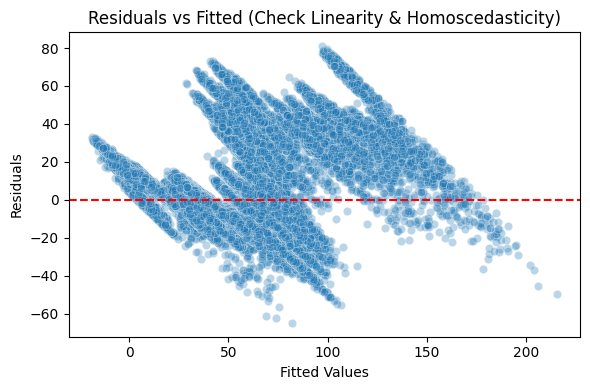

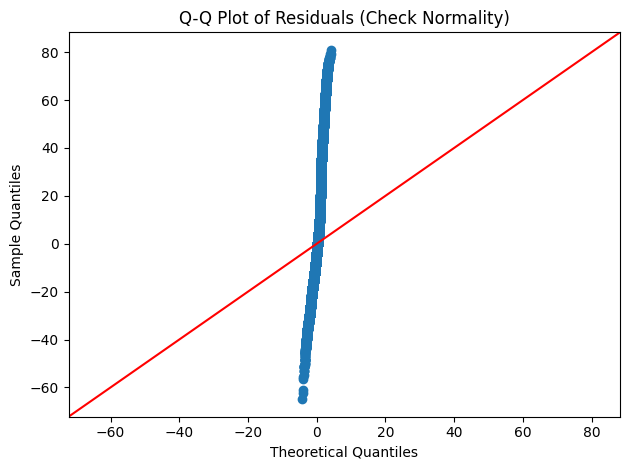

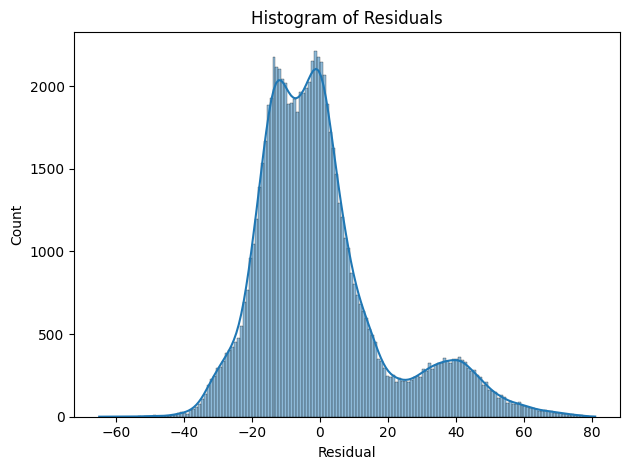

 VIF Results:
               feature       VIF
3                  MIP  2.611768
8                  LTV  2.604772
13         LoanPurpose  1.589122
16    MonthsDelinquent  1.331883
15      EverDelinquent  1.313187
1   FirstTimeHomebuyer  1.189115
7              OrigUPB  1.126031
11       PropertyState  1.087831
14        NumBorrowers  1.069695
17        MortgageRate  1.065312
2                  MSA  1.048023
9              Channel  1.039772
4                Units  1.038444
5            Occupancy  1.037918
12        PropertyType  1.036226
0          CreditScore  1.034581
6                  DTI  1.029859
10                 PPM  1.014269

 Breusch-Pagan Test:
LM Stat = 11577.59, p-value = 0.0000
→ Heteroscedasticity detected

 Durbin-Watson = 1.969
→ Independence of residuals looks good


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

# 1. Fit OLS model using statsmodels
X_const = sm.add_constant(X_lr_scaled)
model = sm.OLS(y, X_const).fit()
residuals = model.resid
fitted = model.fittedvalues

# 2. Linearity & Homoscedasticity: Residuals vs Fitted
plt.figure(figsize=(6, 4))
sns.scatterplot(x=fitted, y=residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Fitted (Check Linearity & Homoscedasticity)")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()

# 3. Normality of residuals: Q-Q plot + histogram
sm.qqplot(residuals, line='45')
plt.title("Q-Q Plot of Residuals (Check Normality)")
plt.tight_layout()
plt.show()

sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.tight_layout()
plt.show()

# 4. Multicollinearity: VIF
vif_df = pd.DataFrame()
vif_df['feature'] = X_lr.columns
vif_df['VIF'] = [variance_inflation_factor(X_lr_scaled, i) for i in range(X_lr_scaled.shape[1])]
print(" VIF Results:")
print(vif_df.sort_values(by='VIF', ascending=False))

# 5. Homoscedasticity: Breusch-Pagan test
bp_test = het_breuschpagan(residuals, X_const)
print("\n Breusch-Pagan Test:")
print(f"LM Stat = {bp_test[0]:.2f}, p-value = {bp_test[1]:.4f}")
if bp_test[1] < 0.05:
    print("→ Heteroscedasticity detected")
else:
    print("→ Homoscedasticity assumption passed")

# 6. Independence of Residuals: Durbin-Watson
dw_stat = durbin_watson(residuals)
print(f"\n Durbin-Watson = {dw_stat:.3f}")
if dw_stat < 1.5 or dw_stat > 2.5:
    print("→ Possible autocorrelation in residuals")
else:
    print("→ Independence of residuals looks good")



📊 Random Forest Regression Results:
MAE: 3.140184129246852
R² Score: 0.9519619287321582


<ipython-input-5-00efc31865f7>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')


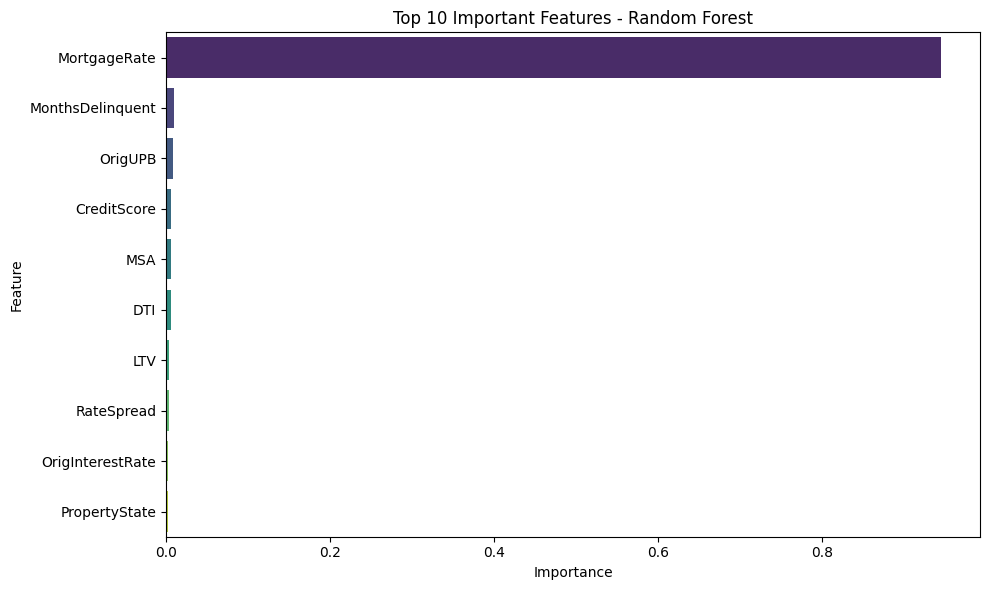

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Train-test split (use raw X here, not scaled, since RF doesn’t need scaling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 3. Predict
y_pred = rf.predict(X_test)

# 4. Evaluation
print("📊 Random Forest Regression Results:")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

# 5. Plot feature importances
importances = rf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')
plt.title("Top 10 Important Features - Random Forest")
plt.tight_layout()
plt.show()



In [6]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Train/test split — MLP requires scaled features
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 2. Define and train the MLP model
mlp = MLPRegressor(hidden_layer_sizes=(128, 64),  # adjust if needed
                   activation='relu',
                   solver='adam',
                   max_iter=500,
                   early_stopping=True,
                   random_state=42)
mlp.fit(X_train, y_train)

# 3. Predict
y_pred = mlp.predict(X_test)

# 4. Evaluation
print("MLP Regressor Results:")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))




MLP Regressor Results:
MAE: 9.10251799833317
R² Score: 0.8257048915728036
